### Exploratory Analysis based on ACLED data from the Sahel region

The Sahel region includes the countries Mauritania, Mali, Burkina Faso, Chad and Niger. For this exploratory data analysis usecase data from the Armed Conflict Location & Event Data Project (ACLED); https://www.acleddata.com was used. For information concerning the methodology of ACLED can be found in: ACLED. (2019). Armed Conflict Location & Event Data Project (ACLED) Codebook, 2019. Only a subset of the data is used for this usecase including the columns "data_id", "country", "iso3", "event_type", "fatalities", "event_date" and the timeperiod from 2015-01-01 until 2020-12-31 (including). The ACLED data is enriched by the variables CC.EST (control of corruption) and GE.EST (government effectiveness) from the Worldwide Government Indicators (WGI) from World Bank - Worldwide Governance Indicators (2021) http://info.worldbank.org/governance/wgi/ via Worldbank API. 

#### Loading libraries and get and join data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wbgapi as wb

path = "./data/acled_sahel.csv"
data = pd.read_csv(path)
data = data[["data_id", "event_date", "year", "iso3", "country", "latitude", "longitude", "event_type", "fatalities"]]
data["count"] = 1

# get worldbank data
data_wb = wb.data.DataFrame(['CC.EST', 'GE.EST'],
                    db = 3,
                    economy = ['MRT', 'MLI', 'BFA', 'TCD', 'NER'],
                    time = range(2015, 2021),
                    timeColumns = True,
                    labels = True,
                    numericTimeKeys=True,
                    columns = 'series'
                    ).reset_index().drop(['time', "Country"], axis = 1).rename(columns={"economy": "iso3", "Time": "year"})
data_wb = data_wb.astype({"year": int}, errors='raise') 

data = data.merge(data_wb, how='left')
data['event_date'] = pd.to_datetime(data['event_date'])
data['event_month'] = data['event_date'].dt.strftime('%Y-%m')
data.to_json("./maps/src/assets/data/point_data.json", orient="records")
data.head()

,data_id,event_date,year,iso3,country,latitude,longitude,event_type,fatalities,count,CC.EST,GE.EST,event_month
0,8013274,2020-12-31,2020,NER,Niger,13.2052,12.4193,Battles,0,1,-0.658867,-0.617085,2020-12
1,8013276,2020-12-31,2020,MLI,Mali,14.3493,-3.6102,Strategic developments,0,1,-0.778714,-1.154480,2020-12
2,8013278,2020-12-31,2020,BFA,Burkina Faso,13.9805,-1.3770,Battles,4,1,-0.101170,-0.669525,2020-12
3,8013281,2020-12-31,2020,MLI,Mali,13.9581,-3.7103,Violence against civilians,1,1,-0.778714,-1.154480,2020-12
4,8013282,2020-12-31,2020,MLI,Mali,14.8059,-6.0182,Violence against civilians,0,1,-0.778714,-1.154480,2020-12


In [3]:
data_2 = data.groupby(['iso3']).agg({"fatalities": "sum", "count": "sum"})
data_2.to_json("./maps/src/assets/data/choropleth_data.json", orient="records")
color_palette = ["#f1eef6", "#bdc9e1", "#74a9cf", "#2b8cbe", "#045a8d"]
data_2["COLOR"] = np.where(data_2['count'] >= 4000, color_palette[4],
    np.where(data_2['count'] >= 2000, color_palette[3], 
    np.where(data_2['count'] >= 1000, color_palette[2],
    np.where(data_2['count'] >= 500, color_palette[1], color_palette[0]))))
data_2 = data_2.reset_index()
data_2.to_json("./maps/src/assets/data/choropleth_data.json", orient="records")
data_2.head()

,iso3,fatalities,count,COLOR
0,BFA,5043,2593,#2b8cbe
1,MLI,8178,3658,#2b8cbe
2,MRT,13,653,#bdc9e1
3,NER,3956,1301,#74a9cf
4,TCD,2334,558,#bdc9e1


#### Summarizing and Grouping

<b>Calculating and visualizing the average fatalities by country for complete timeframe</b>

In [95]:
grouped_statistic = data.groupby("country").agg(
    mean_fatalities = pd.NamedAgg(column="fatalities", aggfunc="mean"),
    mean_cc_est = pd.NamedAgg(column="CC.EST", aggfunc="mean"),
    median_fatalities = pd.NamedAgg(column="fatalities", aggfunc="median"),
    median_cc_est = pd.NamedAgg(column="CC.EST", aggfunc="mean"),
    mode_fatalities = pd.NamedAgg(column="fatalities", aggfunc=pd.Series.mode),
    mode_cc_est = pd.NamedAgg(column="CC.EST", aggfunc="mean"),
)
grouped_statistic

,mean_fatalities,mean_cc_est,median_fatalities,median_cc_est,mode_fatalities,mode_cc_est
country,,,,,,
Burkina Faso,1.944852,-0.148031,0.0,-0.148031,0,-0.148031
Chad,4.182796,-1.417956,0.0,-1.417956,0,-1.417956
Mali,2.235648,-0.716615,0.0,-0.716615,0,-0.716615
Mauritania,0.019908,-0.816595,0.0,-0.816595,0,-0.816595
Niger,3.040738,-0.619873,0.0,-0.619873,0,-0.619873


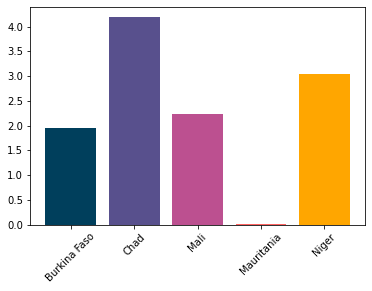

In [96]:
countries = list(grouped_statistic.index)
x_pos = np.arange(len(countries))
y = list(grouped_statistic.mean_fatalities)
color_palette = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#ffa600"]

plt.bar(x_pos, y, color=color_palette)
plt.xticks(x_pos, countries, rotation=45)
plt.show()

<b>Calculating and visualizing the dispersion of fatalities across the countries</b>

In [54]:
grouped_statistic_disp = data.groupby("country").agg(
    min_fatalities = pd.NamedAgg(column="fatalities", aggfunc=np.min),
    max_fatalities = pd.NamedAgg(column="fatalities", aggfunc="max"),
    sd_fatalities = pd.NamedAgg(column="fatalities", aggfunc=np.std),
    var_falities = pd.NamedAgg(column="fatalities", aggfunc=np.var),
    q1_fatalities = pd.NamedAgg(column="fatalities", aggfunc=lambda x: np.percentile(x, 25)),
    q2_fatalities = pd.NamedAgg(column="fatalities", aggfunc=lambda x: np.percentile(x, 50)),
    q3_fatalities = pd.NamedAgg(column="fatalities", aggfunc=lambda x: np.percentile(x, 75)),
    q4_fatalities = pd.NamedAgg(column="fatalities", aggfunc=lambda x: np.percentile(x, 100))

)
grouped_statistic_disp

,min_fatalities,max_fatalities,sd_fatalities,var_falities,q1_fatalities,q2_fatalities,q3_fatalities,q4_fatalities
country,,,,,,,,
Burkina Faso,0,160,5.624898,31.639474,0.0,0.0,1.0,160.0
Chad,0,305,15.113435,228.415906,0.0,0.0,2.0,305.0
Mali,0,157,5.382781,28.974328,0.0,0.0,2.0,157.0
Mauritania,0,2,0.152489,0.023253,0.0,0.0,0.0,2.0
Niger,0,166,9.365495,87.712499,0.0,0.0,2.0,166.0


(array([1, 2, 3, 4, 5]),
 [Text(1, 0, 'Burkina Faso'),
  Text(2, 0, 'Chad'),
  Text(3, 0, 'Mali'),
  Text(4, 0, 'Mauritania'),
  Text(5, 0, 'Niger')])

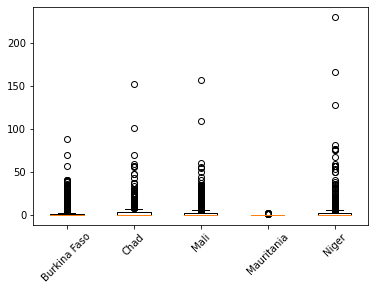

In [97]:
data_dict = {country:list(data[data["country"] == country].fatalities) for country in list(grouped_statistic_disp.index)}

fig, ax = plt.subplots()
ax.boxplot(data_dict.values())
ax.set_xticklabels(data_dict.keys())
plt.xticks(rotation=45)

From the box plot we can see that the distribution of fatalities across the countries are exceptionally left-scewed with many outliers!

#### Relationship between variables

<b>Relationship between control of corruption CC.EST and government effectiveness GE.EST</b>

In [102]:
data_wb = data[["iso3", "country", "year", "CC.EST", "GE.EST"]]
data_wb = data_wb.groupby(["iso3", "country", "year"], as_index = False).agg({"CC.EST": "mean", "GE.EST": "mean"})

cc_est = data_wb["CC.EST"]
ge_est = data_wb["GE.EST"]

print(np.corrcoef(cc_est, ge_est))

[[1.         0.85469245]
 [0.85469245 1.        ]]


As expected the Pearson´s correlation between government effectiveness and control of corruption is high in the Sahel region (0.85).

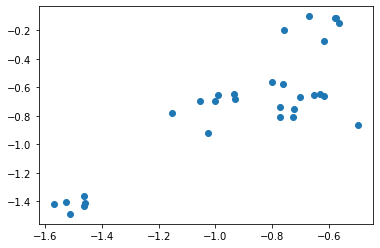

In [103]:
x = list(data_wb["GE.EST"])
y = list(data_wb["CC.EST"])

plt.scatter(x, y)
plt.show()

The strong positive relationship between CC.EST and GE.EST is also visible in the scatter plot.

#### Identify patterns and trends in the data

This time we try to visually identify the trend in the fatalities time series of the events.

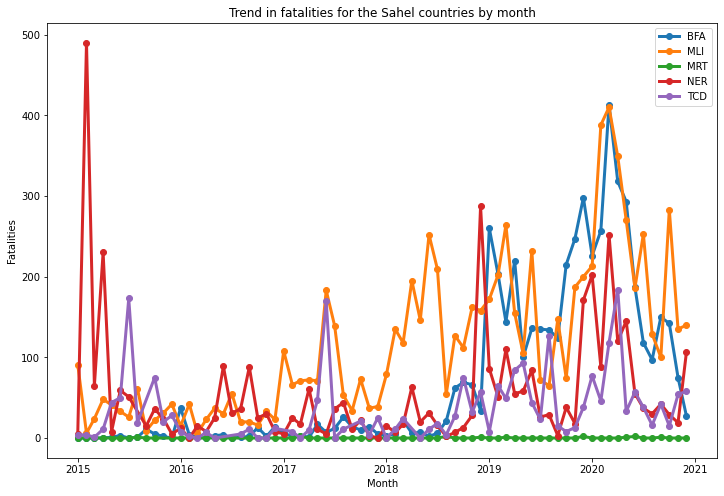

In [137]:
data_event_month = data.groupby(['iso3', 'event_month'], as_index = False).agg({"fatalities": "sum"})
data_event_month['event_month'] = data_event_month['event_month'] + "-01"
data_event_month['event_month'] = pd.to_datetime(data_event_month['event_month'].astype(str), format='%Y-%m-%d')

fig = plt.figure(figsize=(12, 8))
for country in list(data_event_month['iso3'].unique()):
    plt.plot(data_event_month[data_event_month['iso3'] == country]["event_month"], 
            data_event_month[data_event_month['iso3'] == country]["fatalities"], label=country, 
            linewidth=3, marker="o")

plt.title("Trend in fatalities for the Sahel countries by month")
plt.legend()
plt.xlabel("Month")
plt.ylabel("Fatalities")

plt.show()

To visually identify spatial patterns maps are an exceptionally good choice. This can be either choropleth maps or point maps. The application behind the images is deployed via https://tnmayer-maps.netlify.app/

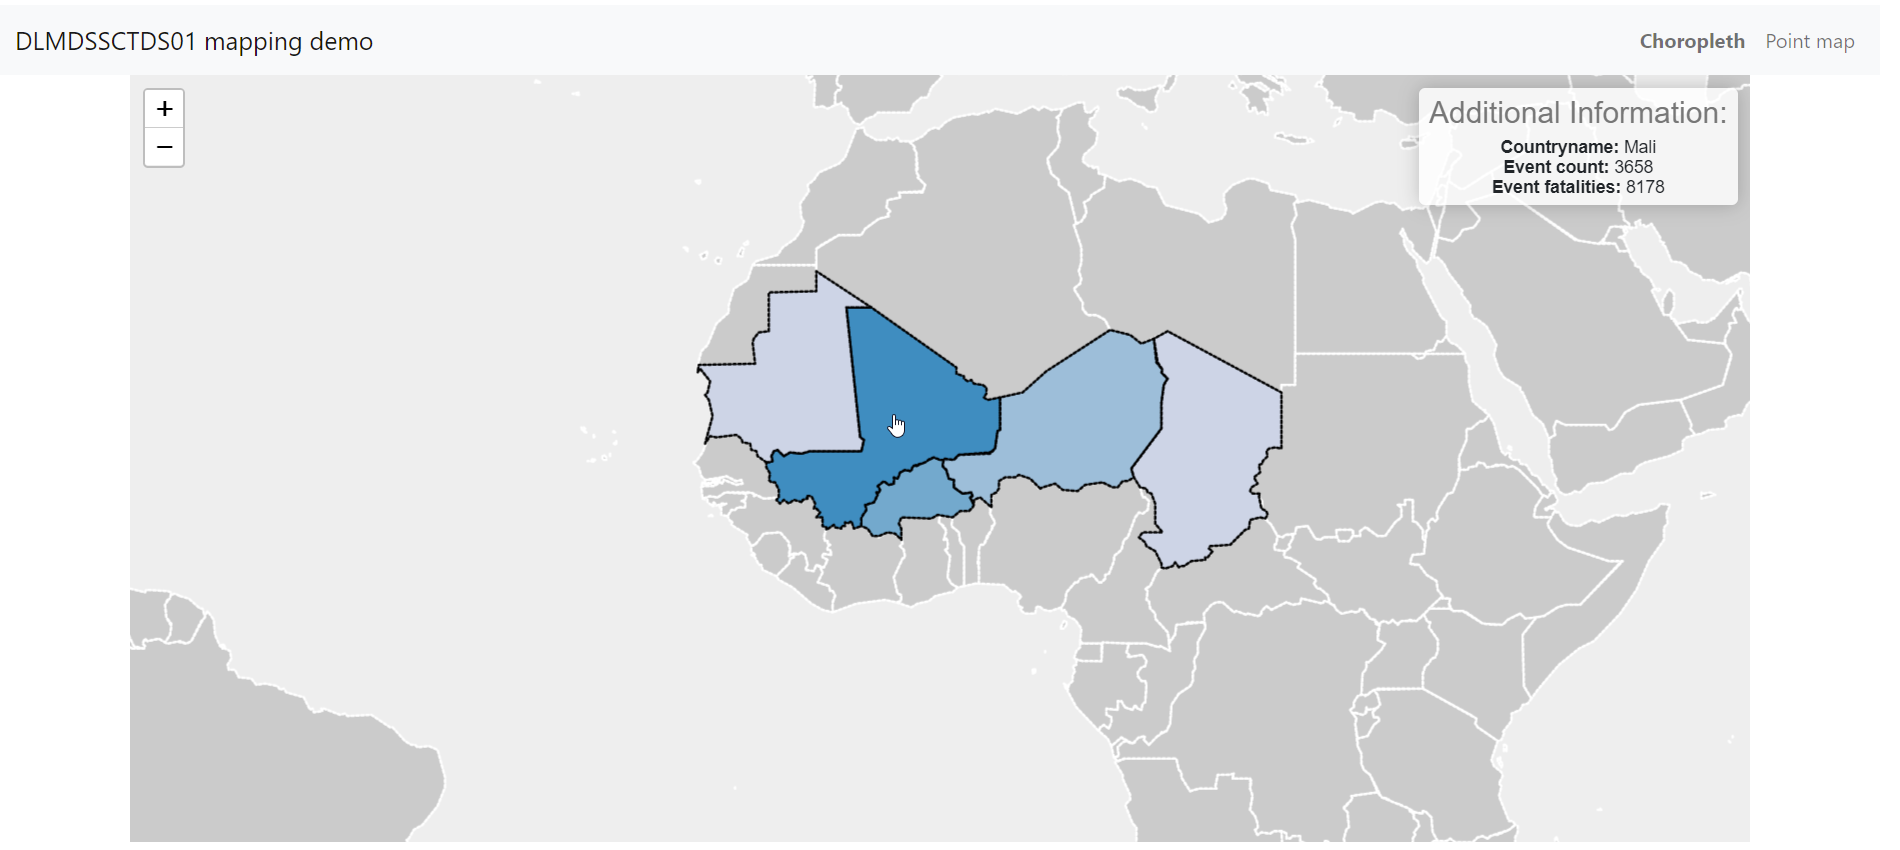

In [1]:
from IPython.display import Image
Image(filename='./images/choropleth.png') 

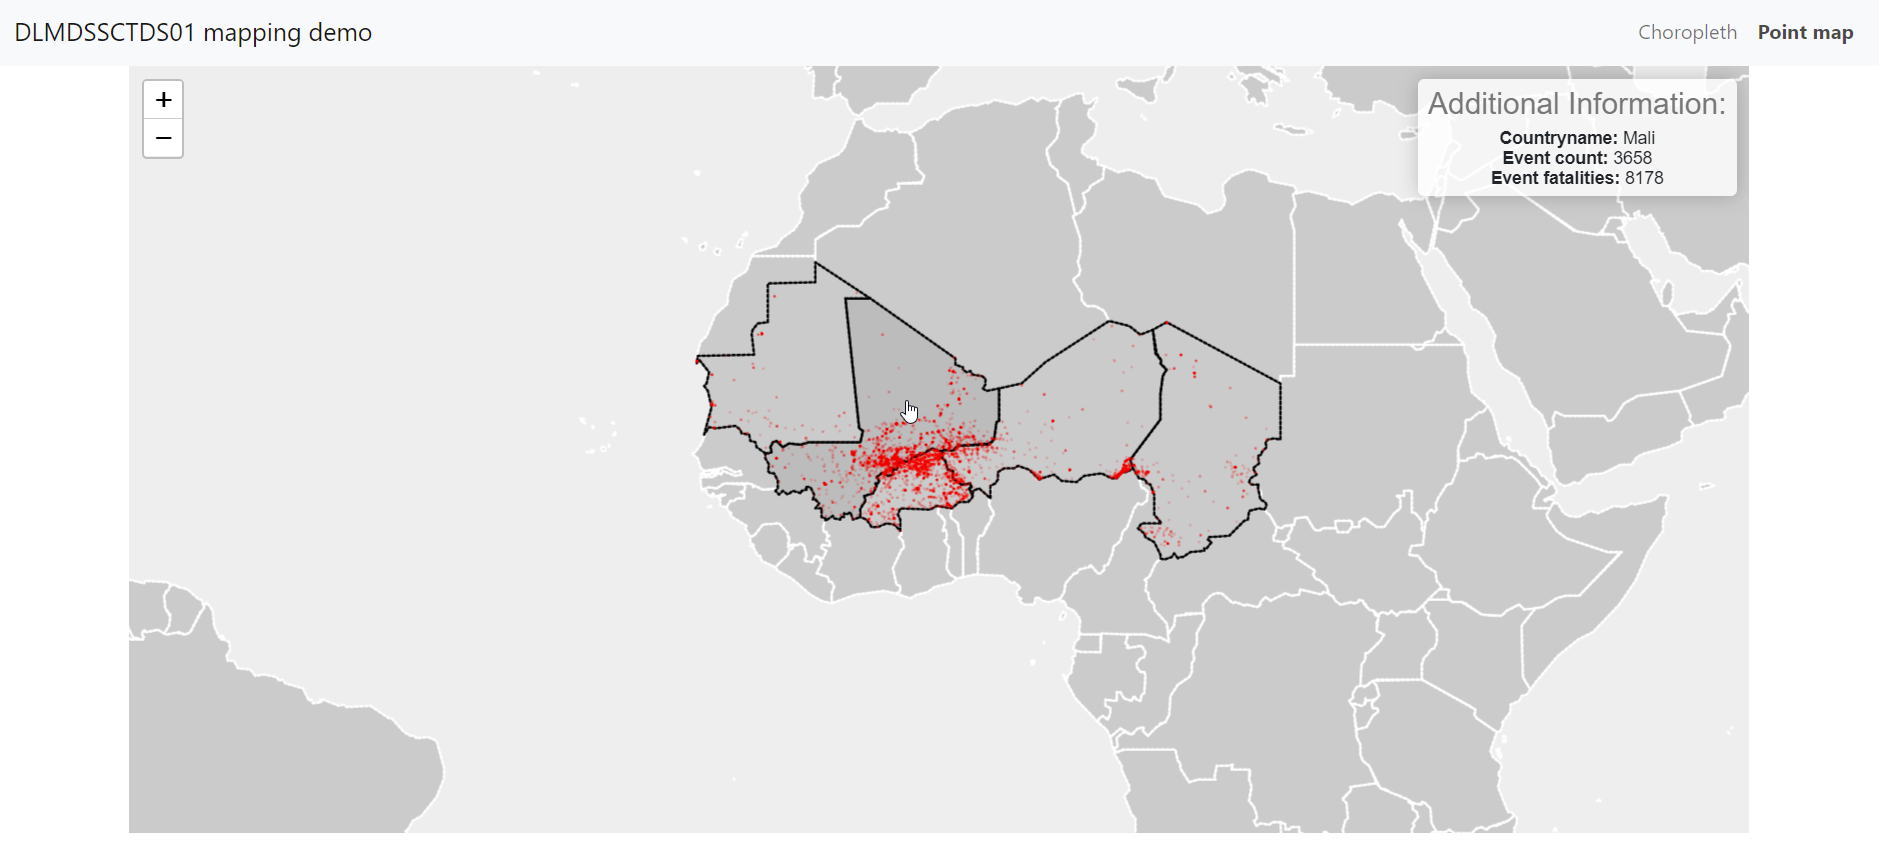

In [2]:
from IPython.display import Image
Image(filename='./images/pointmap.png') 